In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

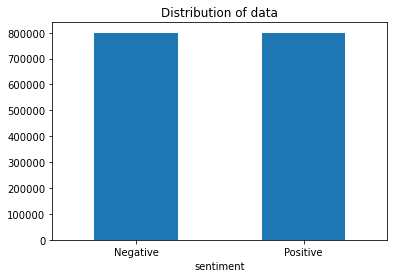

In [28]:
#Importing the dataset
import pandas as pd

DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

#Reading the dataset and selecting relevant columns
dataset = pd.read_csv('TwitterSentiments.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)[["sentiment", "text"]]

#Replacing the sentiment values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

#Plotting the distribution for dataset.
import matplotlib.pyplot as plt

ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

#Storing data in lists.
text = dataset['text'].tolist()
sentiment = dataset['sentiment'].tolist()


In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [29]:
def preprocess(textdata):
    processed_text = []
    lemmatizer = WordNetLemmatizer()
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_pattern = "[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"

    for tweet in textdata:
        # convert tweet to lowercase
        tweet = tweet.lower()

        # Replace URLs with 'URL'
        tweet = re.sub(url_pattern, ' URL', tweet)

        # Replace emojis with corresponding text
        for emoji, value in emojis.items():
            tweet = tweet.replace(emoji, f'EMOJI{value}')

        # Replace @USERNAME with 'USER'
        tweet = re.sub(user_pattern, ' USER', tweet)

        # Replace non-alphanumeric characters with whitespace
        tweet = re.sub(alpha_pattern, ' ', tweet)

        # Replace three or more consecutive letters with two letters
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)

        # Lemmatize words and remove stopwords
        tweet_words = [lemmatizer.lemmatize(word) for word in tweet.split() if len(word) > 1]
        processed_text.append(' '.join(tweet_words))

    return processed_text

In [30]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pierre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 229 seconds


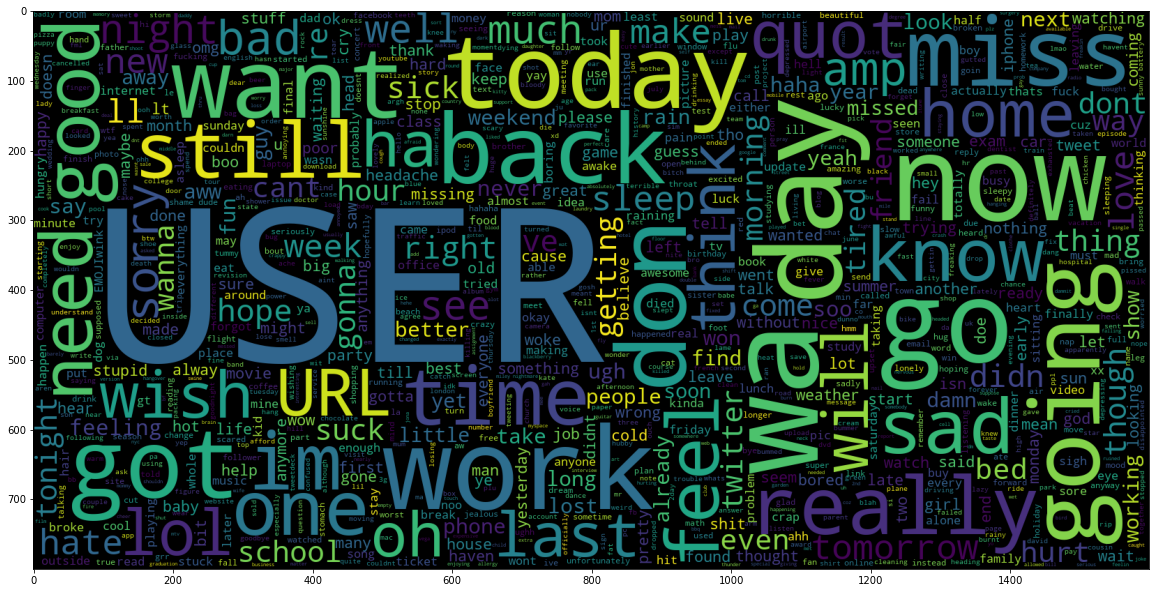

In [8]:
#Word-Cloud for Negative tweets
data_neg = processedtext[:800000]

wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False)
wordcloud.generate(" ".join(data_neg))

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')


(-0.5, 1599.5, 799.5, -0.5)

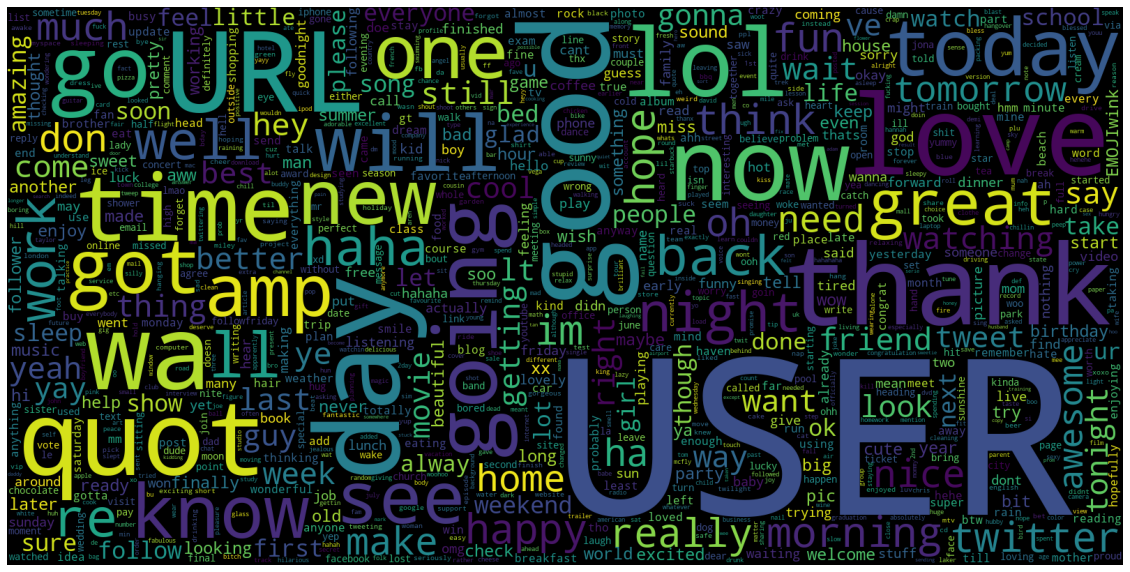

In [32]:
#Word-Cloud for Positive tweets
data_neg = processedtext[:800000]

wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False)
wordcloud.generate(" ".join(data_pos))

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')


In [33]:
from sklearn.model_selection import train_test_split

split_ratio = 0.95  # 95% for training, 5% for testing
split_index = int(len(processedtext) * split_ratio)
X_train, X_test = processedtext[:split_index], processedtext[split_index:]
y_train, y_test = sentiment[:split_index], sentiment[split_index:]
print(f'Data spliting done.')


Data spliting done.


In [34]:
# Initialize a TfidfVectorizer with desired parameters
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)

# Fit the vectorizer to the training data
vectoriser.fit(X_train)

# Print the status message
print(f'TfidfVectorizer fitted.')

# Print the number of feature words
print('Number of feature words:', len(vectoriser.get_feature_names()))

TfidfVectorizer fitted.
Number of feature words: 500000


In [35]:
#transforming the dataset
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Successfully Transformed.')

Data Successfully Transformed.


In [36]:
#function for evaluating the model
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.78      0.87     80000

    accuracy                           0.78     80000
   macro avg       0.50      0.39      0.44     80000
weighted avg       1.00      0.78      0.87     80000



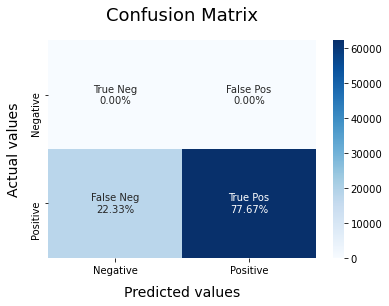

In [43]:
#BernoulliNB Model
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.79      0.88     80000

    accuracy                           0.79     80000
   macro avg       0.50      0.39      0.44     80000
weighted avg       1.00      0.79      0.88     80000



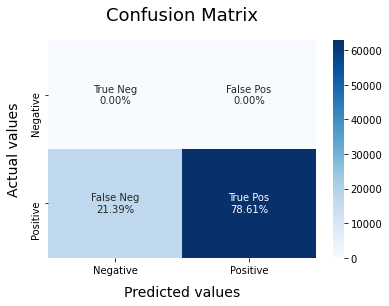

In [45]:
#LinearSVC Model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pierre\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89     80000

    accuracy                           0.80     80000
   macro avg       0.50      0.40      0.44     80000
weighted avg       1.00      0.80      0.89     80000



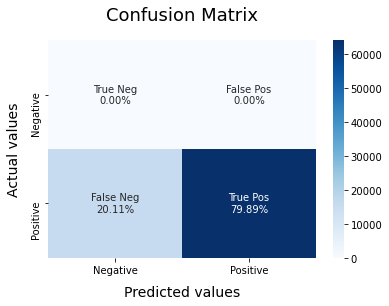

In [46]:
#Logistic Regression Model
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [47]:
#saving the models locally
file = open('vectoriser','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('LRmodel','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('BNBmodel','wb')
pickle.dump(BNBmodel, file)
file.close()

In [48]:
#using the model
def load_models():
    
    # Load the vectoriser.
    file = open('vectoriser', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('LRmodel', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    #Classifying text
    text = ["I love volunteering in charities",
            "I hate politics.",
            "Anita, I feel unwell",
           "I feel relaxed after taking a roadtrip during the weekend"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                                text sentiment
0                   I love volunteering in charities  Positive
1                                   I hate politics.  Negative
2                               Anita, I feel unwell  Negative
3  I feel relaxed after taking a roadtrip during ...  Positive
